# Main Analysis

This file does not rely on user input. So we would like to keep it interchangeable with the actual main_analysis.py file.
So please keep all the >relevant< code within one code block. (If you want to inspect certain elements or do other things that are not relevant to the main analysis, you can of course add them in new blocks).

In [1]:
import sys
import os.path as op
module_path = op.abspath(op.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import mne

from data_analysis.functions_preprocessing import \
    (combine_raws, split_raws, preprocess_single_sub, mark_bads_and_save,
     run_ica_and_save)
from data_analysis.functions_behavioral import \
    (create_event_df, remove_ghost_triggers, calculate_alpha,
     join_event_dfs, remove_outliers, events_from_event_df)
from data_analysis.functions_connectivity import \
    epochs_ispc
from data_analysis.functions_graph_theory import \
    epochs_weighted_small_world_coeff



subject_dir = "/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/"
behav_dir = "/net/store/nbp/projects/hyperscanning/study_project/NBP_Hyperscanning/data_analysis/Behavioural_Analysis/BehaviouralData"



# Main Data Analysis ###################################
# initialize containers to analyze later
connectivity_matrices = []
small_world_coeffs = []

# Perform the data analysis
for subj_pair in ['202']:  #['202','203','204','205','206','207','208','209','211','212']:

    subs_path = subject_dir + "sub-{0}/eeg/sub-{0}_task-hyper_eeg.fif".format(subj_pair)
    behav_path = op.join(behav_dir, "{0}.csv".format(subj_pair))

    combined_raw = mne.io.read_raw_fif(subs_path, preload=True)

    # split the subjects and delete the raw file
    raws = split_raws(combined_raw)
    del combined_raw

    # apply the preprocessing
    for idx, raw in enumerate(raws):
        subj_idx = "sub-{0}_p-{1}".format(subj_pair, idx)
        raws[idx] = preprocess_single_sub(raw, subj_idx)


    # combine the subjects again
    raw_combined = combine_raws(raws[0], raws[1])
    del raws  # to save memory

    # do the behavioral analysis and get the epochs
    behavioral_df = calculate_alpha(pd.read_csv(behav_path))
    
    event_df = create_event_df(raw_combined)
    event_df = remove_ghost_triggers(event_df)
    event_df = join_event_dfs(event_df, behavioral_df)
    event_df = remove_outliers(event_df, exclude_stddev=2)
    events = events_from_event_df(event_df)

    # define the parameters for epoching
    # TODO: Define events more elaborate!
    event_id = 11
    tmin = 0
    tmax = 1

    # epoch the data. Here we filter out bad segments from both participants
    # TODO: do we need a baseline for the connectivity analysis?
    epochs = mne.Epochs(raw_combined, events, event_id, tmin, tmax,
                        picks=["eeg"], baseline=(0, 0),
                        reject_by_annotation=True)[:10] # only use the first ten epochs
    
    # calculate the ISPC
    freqs = np.arange(5,15,5)
    cycles = freqs / 2.
    ispc_matrix, freqs, times = epochs_ispc(epochs, freqs, cycles, n_jobs=4)
    
    print("ISPC DONE")
    
    # calculate the small world coefficient
    small_worlds = epochs_weighted_small_world_coeff(ispc_matrix)
    
    # append the results to the respective lists
    connectivity_matrices.append(ispc_matrix)
    small_world_coeffs.append(small_worlds)




Bad key "text.kerning_factor" on line 4 in
/net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Opening raw data file /net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-202/eeg/sub-202_task-hyper_eeg.fif...


<ipython-input-1-74079d8c78f5>:40: RuntimeWarning: This filename (/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-202/eeg/sub-202_task-hyper_eeg.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  combined_raw = mne.io.read_raw_fif(subs_path, preload=True)


Isotrak not found
    Range : 0 ... 3725311 =      0.000 ...  3637.999 secs
Ready.
Opening raw data file /net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-202/eeg/sub-202_task-hyper_eeg-1.fif...
Isotrak not found
    Range : 3725312 ... 5675445 =   3638.000 ...  5542.427 secs
Ready.
Reading 0 ... 5675445  =      0.000 ...  5542.427 secs...
[[0. 0. 0. ... 0. 0. 0.]]
[[-0.00904885 -0.00904622 -0.00904523 ... -0.00114    -0.00114062
  -0.00114651]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


ValueError: DONT GO FURTHER!

In [2]:
# NOTE: There seems to be a bug in the data from the very beginning.
# The channels are somehow already referenced, even though we don't have a ref.
# and the one thats supposed to be mapped to Cz (for subject 2) is not the one thats referenced.
# Instead, the Oz electrode was used for the reference. Looks like we have to dig in the script from Max.
# Or change the mapping order.
print(raw_combined.get_data(picks=["sub1_Cz", "sub2_Oz"]))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Investigate stuff

Here, you can look into all the stuff, connectivity matrices etc.

In [2]:
#event_df[event_df["alpha"] > 360]
event_df

,sample,event_code,event_index,event_name,pair,condition,block,trial,subject,tapnr,ttap,jitter,player_start_first,diff_inter,diff_intra,alpha,alpha_lin
0,274640,6,16,s1/t1,202,blind,1,1,1,1,3.216545,0.025,1,-0.246290,0.895074,99.058151,99.058151
1,275557,7,18,s1/t2,202,blind,1,1,1,2,4.111619,0.025,1,-0.045056,0.802895,20.202038,20.202038
2,276379,8,20,s1/t3,202,blind,1,1,1,3,4.914514,0.025,1,-0.035124,0.791843,15.968645,15.968645
3,277190,9,22,s1/t4,202,blind,1,1,1,4,5.706357,0.025,1,-0.010081,0.824135,4.403519,4.403519
4,278033,10,25,s1/t5,202,blind,1,1,1,5,6.530492,0.025,1,0.018826,0.725878,9.336779,9.336779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,5633054,19,6637,s2/t5,202,blind,12,300,2,5,7.135232,0.075,2,0.023280,0.876054,9.566494,9.566494
5396,5633951,20,6639,s2/t6,202,blind,12,300,2,6,8.011286,0.075,2,0.110098,0.725927,54.599474,54.599474
5397,5634694,21,6641,s2/t7,202,blind,12,300,2,7,8.737213,0.075,2,0.069454,0.778894,32.101191,32.101191
5398,5635492,22,6643,s2/t8,202,blind,12,300,2,8,9.516107,0.075,2,0.037360,0.814203,16.518709,16.518709


Freqs:  [ 5. 10.]


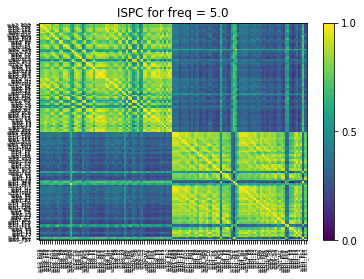

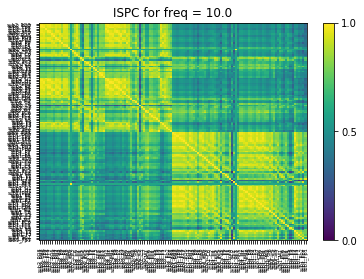

In [3]:
# plot the ISPC matrix
from functions_connectivity import plot_connectivity_matrix

print("Freqs: ", freqs)

plot_connectivity_matrix(np.squeeze(ispc_matrix[0, :,:,0]), epochs.ch_names, title="ISPC for freq = "+ str(freqs[0]))

plot_connectivity_matrix(np.squeeze(ispc_matrix[0, :,:,1]), epochs.ch_names, title="ISPC for freq = "+ str(freqs[1]))

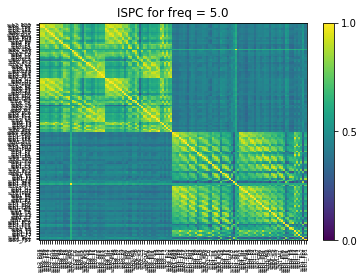

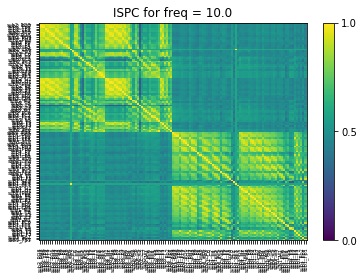

In [4]:
# plot the average ISPC matrix
avg_ispc = np.mean(ispc_matrix, axis=0)

plot_connectivity_matrix(np.squeeze(avg_ispc[:,:,0]), epochs.ch_names, title="ISPC for freq = "+ str(freqs[0]))
plot_connectivity_matrix(np.squeeze(avg_ispc[:,:,1]), epochs.ch_names, title="ISPC for freq = "+ str(freqs[1]))

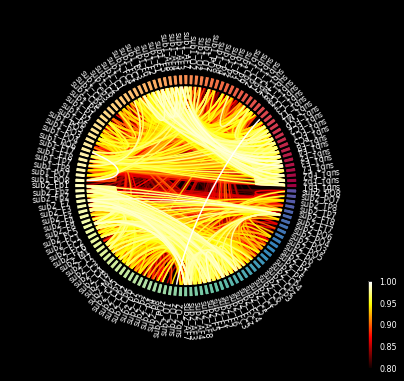

(<Figure size 576x576 with 2 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x7fa6bc74f430>)

In [5]:
# plot a connectivity circle
from mne.viz import plot_connectivity_circle

mne.viz.plot_connectivity_circle(ispc_matrix[0, :,:,1], epochs.ch_names, vmin=0.8)

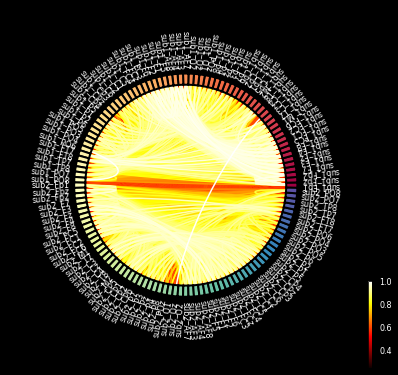

(<Figure size 576x576 with 2 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x7fa6bc6dde20>)

In [6]:
# plot a connectivity circle for the average matrix

mne.viz.plot_connectivity_circle(avg_ispc[:,:,1], epochs.ch_names)

In [7]:
print(np.where(np.array(epochs.ch_names) == "sub1_Cz"),
      np.where(np.array(epochs.ch_names) == "sub2_Oz"))

ispc_matrix[:, 15, 94, 1]
epochs.get_data()[:,15,:]
epochs.get_data()[:,94,:]

(array([15]),) (array([94]),)
Loading data for 10 events and 1025 original time points ...
Loading data for 10 events and 1025 original time points ...


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])